In [1]:
import scipy
import numpy as np
from matplotlib import cm,colors, rc
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from control import dare
import single_photons.utils.constants as ct
from single_photons.utils.parameters import *
from single_photons.utils.optical_input import *
from single_photons.utils.metrics import *
from single_photons.environment import Cavity_Particle
from single_photons.simulation.simulation_cavity import simulation_c

/Users/oscarkremer/miniconda3/lib/python3.8/site-packages/single_photons-0.0.1-py3.8.egg/single_photons/simulation/simulation_particle.py:3: NumbaPendingDeprecationWarning: The 'pycc' module is pending deprecation. Replacement technology is being developed.

Pending Deprecation in Numba 0.57.0. For more information please see: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-the-numba-pycc-module


In [2]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams.update({
    "text.usetex": True,
})
plt.rcParams['figure.dpi'] = 200 #600 for figure generation
C = ['#2E86C1', '#85C1E9', '#1B4F72']

In [3]:
def custom_optical_input(N, delta_t, photon_number, kappa, cavity_length, detuning, wavelength, duration, phase):
    FSR, f, r, I_factor = compute_cavity_parameters(kappa, cavity_length, detuning, wavelength)
    #I_factor = 1/(1-r)^2
    amplitude = np.sqrt(photon_number * I_factor)*(1*np.cos(phase)+1j*np.sin(phase))
    optical_input = 1j*np.zeros((4,N))
    end = int(duration/delta_t)
    end = min(N,int(N/2) + end)
    s = end - int(N/2)
    optical_input[0,int(N/2):end] = np.array(s*[(np.conjugate(amplitude) + amplitude) * np.sqrt(kappa) * delta_t])
    optical_input[1,int(N/2):end] = np.array(s*[1j*(np.conjugate(amplitude) - amplitude) * np.sqrt(kappa) * delta_t])
    return FSR, f, r, I_factor, optical_input

def custom_SNR(signal,start,duration):
    ref = signal[start - duration:start]
    snr = np.mean(np.power(signal[start:start + duration],2)) / np.mean(np.power(ref,2))
    return snr

def post_process_snr(snr):
    if not np.equal(snr, None).sum():
        mean_pos = np.mean(snr)
        std_pos = np.std(snr)
    else:
        mean_pos = 0
        std_pos = 0
    return mean_pos, std_pos

In [25]:
delta_t = 5e-9
rho = 2200
index_refraction = 1.4440
T = 293
p = 9.2e-7
radius = 71.5e-9
wavelength = 1.064e-6
power = 300e-3
eta_detection = 0.3 #0.178 = info
control_step = int(32e-9/delta_t) 
fs = 1/(control_step*delta_t)
tweezer_waist = 3.7352e-6#np.sqrt(0.67*0.77)*1e-6 
g_fb_ratio = 50
laser_linewidth = 0
omega = 2*np.pi*104e3
period = 2*np.pi/omega

t = np.arange(0, 300*period, delta_t)
N = t.shape[0]
zp_x = compute_zpx(omega, radius, rho = rho)

cavity_length = 0.03
cavity_length = compute_resonance_length(cavity_length,wavelength)
photon_number = 4
duration = 50e-6
step = 40

linewidths = omega*np.linspace(0.2,5,50)
detunings = np.linspace(-0.5,0.5,50)
SNR_data = np.zeros((linewidths.shape[0],detunings.shape[0]))

print('Dynamical instability if 4*(g_cs/omega)**2/detuning_ratio>1 (Kustura)')

Dynamical instability if 4*(g_cs/omega)**2/detuning_ratio>1 (Kustura)


In [29]:
num_phase = 20
states_sim = np.zeros((num_phase, t.shape[0], 4)).astype(np.complex_)
for i, phase in enumerate(np.linspace(0, 2*np.pi, num_phase)):
    if 'phonons' in globals():
        del phonons
    detuning_ratio = 0
    cavity_linewidth = omega*0.5
    gamma, ba_force, std_detection, std_z, g_cs, detuning =\
    compute_parameters_simulation_cavity(power, wavelength, tweezer_waist, radius, p, fs, eta_detection, 
                                            cavity_length, detuning_ratio, cavity_linewidth, omega,
                                            T = T, rho = rho, index_refraction = index_refraction)
    std_detection = std_detection/zp_x
    coupling = (1/(4*np.pi))*(ba_force**2)
    x0 = 0
    P0 = std_detection**2 * np.eye(4)

    env = Cavity_Particle(
        omega,
        gamma,
        detuning,
        cavity_linewidth,
        g_cs,
        coupling,
        radius=radius,
        eta_detection=eta_detection,
        T=T,
        g_fb_ratio = g_fb_ratio
    )

    FSR, f, r, I_factor, optical_input = custom_optical_input(
        N, delta_t, photon_number, env.__kappa__, cavity_length, detuning, wavelength, duration, phase=phase)
    variance_process = env.thermal_force_std**2 + env.backaction_std**2
    Q = control_step*delta_t/2*np.array(
        [
            [env.__shot_std__**2, 0, 0, 0],
            [0, env.__shot_std__**2, 0, 0],
            [0, 0, 0, 0],
            [0, 0, 0, variance_process]
        ])
    R = np.array([[np.power(std_detection, 2)]])
    Ad = scipy.linalg.expm(env.A *control_step*delta_t)
    Bd = env.B * delta_t * control_step
    #Bd = np.linalg.pinv(env.A)@(scipy.linalg.expm(env.A *delta_t * control_step) - np.eye(4))@env.B
    cov_ss = dare(Ad.T, Bd, Q, R)[0]

    new_states, measured_states, estimated_states, cov_aposteriori, controls = simulation_c(
        env.A,
        env.B, 
        optical_input,
        env.thermal_force_std,
        env.backaction_std,
        env.__shot_std__,
        std_detection, 
        eta_detection,
        x0, 
        P0, 
        Ad, 
        Bd, 
        env.C, 
        env.G,
        env.G_lqr,
        Q, 
        R, 
        delta_t, 
        control_step, 
        N
    )
    states_sim[i, :, :] = estimated_states
    

In [40]:
np.imag(states_sim[10,:,1]).sum()

0.0

(290000.0, 310000.0)

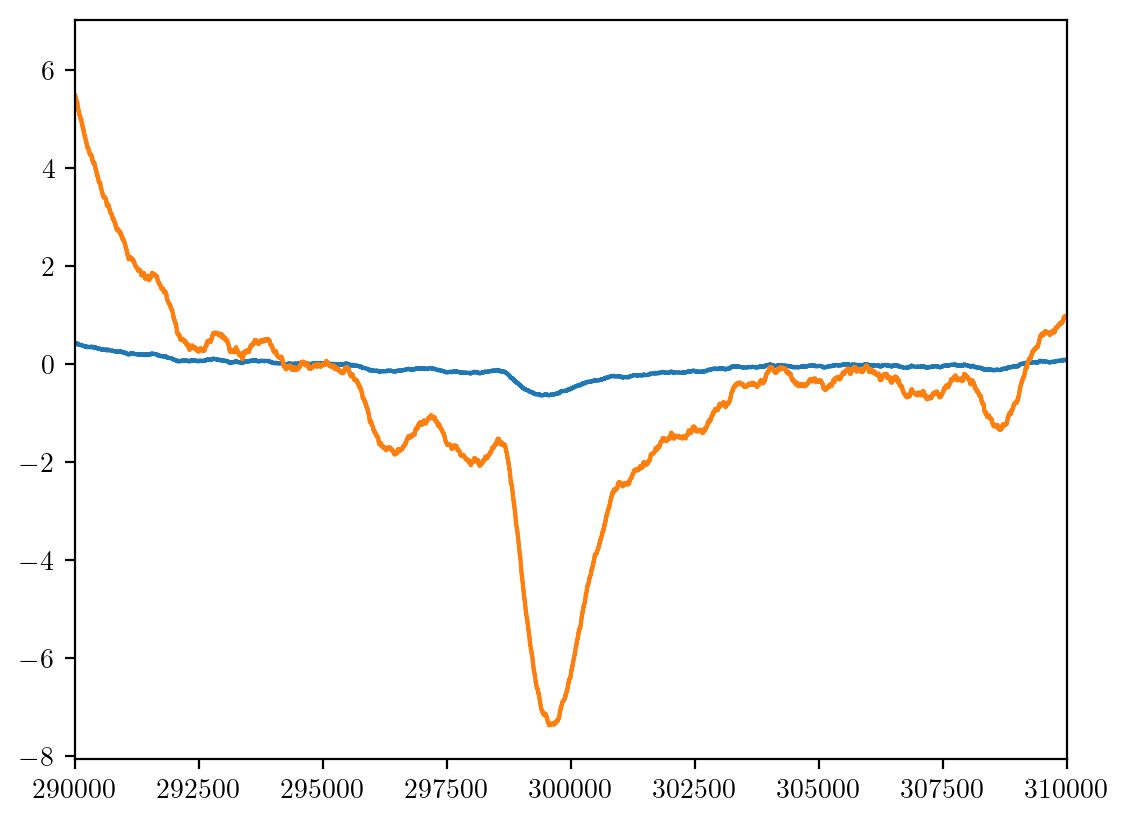

In [44]:
#for i in range(num_phase):
plt.plot(states_sim[5,:,0]/states_sim.max(axis=0))
plt.plot(states_sim[5,:,1])    
plt.xlim([290000,310000])

Text(0, 0.5, '$\\Delta/\\Omega$')

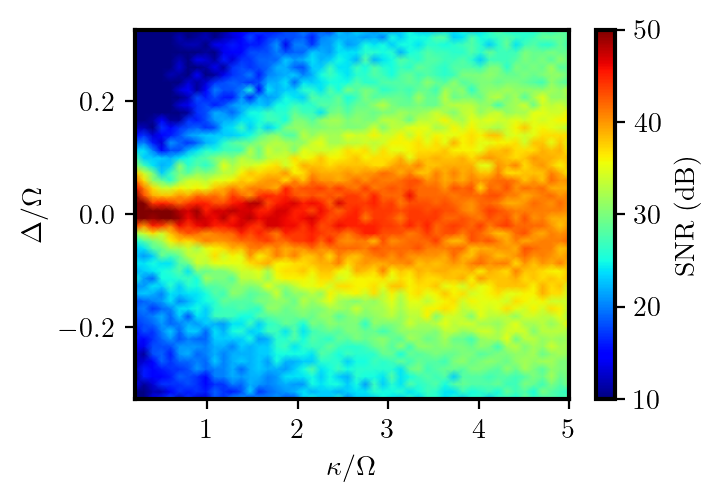

In [20]:
factor = 1
fig = plt.figure()
plt.rcParams.update({'font.size': 10})
plt.rcParams['axes.linewidth'] = 1.5
fig.set_size_inches(3.5*factor, 2.4*factor, forward = True)

#upper = cm.jet(np.arange(256))
#lower = np.ones((int(256/4),4))
#for i in range(3):
#    lower[:,i] = np.linspace(1, upper[0,i], lower.shape[0])
#cmap = np.vstack(( lower, upper ))
#cmap = colors.ListedColormap(cmap, name='myColorMap', N=cmap.shape[0])
Z = np.loadtxt('SNR_backup.txt', usecols=range(50))
X,Y = np.meshgrid(linewidths/omega,detunings*omega/1e6)
plt.pcolormesh(X,Y,Z.T,shading = 'gouraud', cmap = 'jet', vmin=10, vmax=50)
plt.colorbar(label = 'SNR (dB)')
#plt.xscale('log')
plt.xlabel(r'$\kappa/\Omega$')
plt.ylabel(r'$\Delta/\Omega$')
#np.savetxt('SNR_backup.txt', Z, fmt='%d')

In [15]:
Z

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Text(0, 0.5, 'linewidth [MHz]')

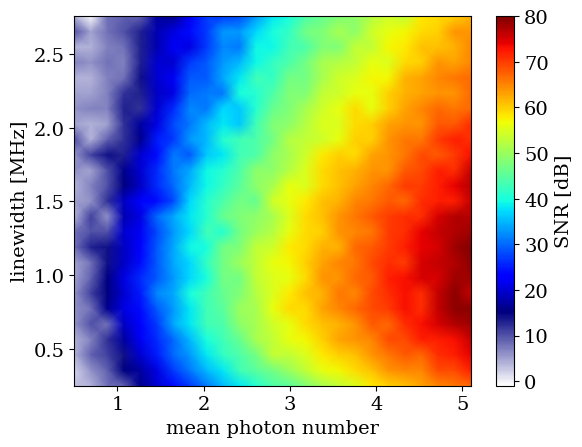

In [ ]:
b = np.loadtxt('SNR_backup.txt', dtype=float)
plt.pcolormesh(X,Y,b,shading = 'gouraud',cmap = cmap)
plt.colorbar(label = 'SNR [dB]')
plt.xlabel('mean photon number')
plt.ylabel('linewidth [MHz]')

In [41]:
print(Y)
print(mean_pos)
print(error_pos)
print(error_phn)

[[[9.69156339e+01+0.j 8.12746340e+00+0.j]
  [1.47249863e+04+0.j 1.24945314e+03+0.j]]]
[(19.86393840796271+0j)]
[[(19.483551074301424+0j)], [(20.213675189575735+0j)]]
[[(41.295459569668296+0j)], [(42.03425627113716+0j)]]


C:\Users\jorge\anaconda2023.3\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


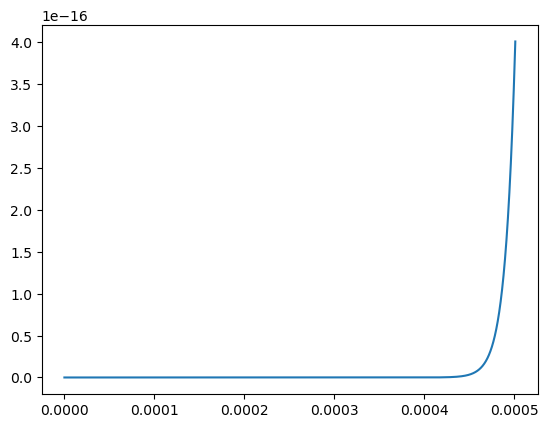

In [22]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
plt.plot(t[:int(0.2*t.shape[0])],optical_input[0,:int(0.2*optical_input[0].shape[0])])
plt.show()

In [51]:
reps = 50
max_x = np.zeros(reps)
max_y = np.zeros(reps)

for i in tqdm(range(reps)):
    optical_input, centers, pulse_width = create_pulse(photon_number, env.__kappa__, 
                                                           laser_linewidth, t,
                                                           cavity_length, cavity_linewidth,
                                                           env.__detuning__, pulse_width = width)
    max_x[i] = max(np.abs(optical_input[0]))
    max_y[i] = max(np.abs(optical_input[1]))



100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:44<00:00,  1.12it/s]


In [34]:
print(SNR_data)

[[41.11657665 39.66123673 36.50617095 34.06291459 32.69203207 31.76331802
  29.63926232 30.27236579 27.20246569 23.58066158 25.64444061 25.64298044
  24.05305322 20.63472936 21.0367204  22.00839764 18.09382872 20.10857171
  17.63362546 18.92988573]
 [42.68100664 41.80516406 38.96606106 39.77343103 34.26154616 33.15949787
  33.31744426 32.80650797 32.52133512 32.62711441 28.43590161 26.76899894
  27.37472704 28.25695166 26.04390343 24.01619109 25.69724135 23.92316118
  22.49849141 21.71000691]
 [40.64165304 38.55014516 38.69906138 35.22193372 36.7253266  37.59105883
  33.95251719 34.4788485  33.60497002 30.77087586 30.17473142 29.10839578
  29.23540876 31.11007852 26.11454738 28.00210073 27.45789393 27.08070352
  25.85643599 26.1963681 ]
 [37.30814004 38.08303467 36.52002925 38.20265056 36.08705726 35.56780884
  34.49529692 31.70658461 32.57168012 32.15269913 34.63703312 31.75465783
  30.88836438 32.35719467 29.54106919 29.20710596 27.75679667 23.65093925
  29.22259033 27.04163628]
 [35